# MLP for TF Function

In [8]:
import torch 
import pandas as pd 
import pickle
import numpy as np
import os
import sys 

from torch.utils.data import Dataset, DataLoader
from torch import nn


import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from tqdm import trange

sns.set_theme()

## Data

In [9]:
# Load data
freq_data = np.genfromtxt("TTF_Data_100.000_1.500_2.500.csv.csv")

# Load pickle
with open("TTF_data.pt", "rb") as f:
    TTF_data = pickle.load(f)

with open("Vs_values.pt", "rb") as f:
    Vs_data = pickle.load(f)

TTF_data = np.array(TTF_data)
Vs_data = np.array(Vs_data)

# Get Vs_data less than 800
index = Vs_data < 420
TTF_data = TTF_data[index]
Vs_data = Vs_data[index]

print(TTF_data.shape, Vs_data.shape)

# Use only certain freq
idx = 0
freq = freq_data[:]
print(freq, idx)

(67, 256) (67,)
[0.1        0.10122847 0.10247203 0.10373087 0.10500518 0.10629513
 0.10760094 0.10892278 0.11026087 0.11161539 0.11298655 0.11437456
 0.11577962 0.11720194 0.11864173 0.12009921 0.12157459 0.1230681
 0.12457996 0.12611039 0.12765962 0.12922788 0.1308154  0.13242243
 0.1340492  0.13569596 0.13736294 0.13905041 0.1407586  0.14248778
 0.1442382  0.14601013 0.14780382 0.14961954 0.15145758 0.15331819
 0.15520166 0.15710826 0.15903829 0.16099203 0.16296977 0.16497181
 0.16699844 0.16904997 0.1711267  0.17322894 0.17535701 0.17751122
 0.17969189 0.18189935 0.18413393 0.18639596 0.18868578 0.19100373
 0.19335016 0.19572541 0.19812984 0.20056381 0.20302767 0.20552181
 0.20804659 0.21060238 0.21318957 0.21580854 0.21845968 0.2211434
 0.22386008 0.22661013 0.22939397 0.23221201 0.23506467 0.23795237
 0.24087555 0.24383463 0.24683007 0.2498623  0.25293179 0.25603898
 0.25918435 0.26236835 0.26559147 0.26885418 0.27215698 0.27550035
 0.27888479 0.28231081 0.28577891 0.28928963 0.2

In [10]:
# Separate the 10 values randomly for testing
test_indices = np.random.choice(len(TTF_data), 10, replace=False)
test_TTF_data = TTF_data[test_indices][:, :]
test_Vs_data = Vs_data[test_indices]

train_indices = np.delete(np.arange(len(TTF_data)), test_indices)
train_TTF_data = TTF_data[train_indices][:, :]
train_Vs_data = Vs_data[train_indices]

print("Training data size: " ,train_TTF_data.shape, train_Vs_data.shape)
print("Testing data size: ", test_TTF_data.shape, test_Vs_data.shape)

Training data size:  (57, 256) (57,)
Testing data size:  (10, 256) (10,)


In [11]:
# Create Meshgrid
freq_values, Vs_values = np.meshgrid(freq, train_Vs_data)
print(Vs_values.shape, freq_values.shape, train_TTF_data.shape)

# Flatten the meshgrid
Vs_values = Vs_values.flatten()
freq_values = freq_values.flatten()
TTF_values = train_TTF_data.flatten()
print(Vs_values.shape, freq_values.shape, TTF_values.shape)

(57, 256) (57, 256) (57, 256)
(14592,) (14592,) (14592,)


In [12]:
class TTFDataset(Dataset):
    def __init__(self, TTF_data, Vs_array, freq_array):
        self.TTF_data = TTF_data
        self.Vs_array = Vs_array
        self.freq_array = freq_array

    def __len__(self):
        return len(self.TTF_data)

    def __getitem__(self, idx):

        # Input 
        Vs = self.Vs_array[idx] * np.ones(30)
        freq = self.freq_array[idx] * np.ones(1)
        input_data = np.concatenate((Vs, freq))
        input_data = torch.tensor(input_data, dtype=torch.float32)

        # Target
        TTF = self.TTF_data[idx] * np.ones(1)
        target = torch.tensor(TTF, dtype=torch.float32)

        return input_data, target

In [13]:
# Normalize the data
def normalize_data(data, mean, std):
    return (data - mean) / std

def denormalize_data(data, mean, std):
    return data * std + mean

# Normalize the data
mean_Vs = Vs_values.mean()
std_Vs = Vs_values.std()
mean_freq = freq_values.mean()
std_freq = freq_values.std()
mean_TTF = TTF_values.mean()
std_TTF = TTF_values.std()

Vs_values = normalize_data(Vs_values, mean_Vs, std_Vs)
freq_values = normalize_data(freq_values, mean_freq, std_freq)
TTF_values = normalize_data(TTF_values, mean_TTF, std_TTF)

# Create dataset
dataset = TTFDataset(TTF_values, Vs_values, freq_values)

In [14]:
# Separate into training and testing
train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size
print("Train, validation and test sizes: " ,train_size, val_size, test_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

i_batch_size = 5000
train_loader = DataLoader(train_dataset, batch_size=i_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=i_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=i_batch_size, shuffle=True)
print("Number of batches: ", len(train_loader), len(val_loader), len(test_loader))

Train, validation and test sizes:  11673 1459 1460
Number of batches:  3 1 1


## Model

In [15]:
# Create Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_layers, output_dim=1, activation=nn.ReLU, batch_norm=False):
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.batch_norm = batch_norm
        self.activation = activation
        self.output_dim = output_dim

        # Input layer
        self.hidden_layers.append(nn.Linear(input_dim, hidden_dim))
        if self.batch_norm:
            self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Hidden layers
        for _ in range(hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
            if self.batch_norm:
                self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Output layer
        self.out = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                x = layer(x)
                x = self.activation()(x)
            elif isinstance(layer, nn.BatchNorm1d):
                x = layer(x)
        x = self.out(x)
        return x

In [16]:
# Create TF model
class TF_model(nn.Module):
    def __init__(self, input_dim=31, output_dim=1):
        super(TF_model, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.fmlp1 = MLP(input_dim-1, 30, 2, output_dim=1, activation=nn.ReLU)
        self.fmlp2 = MLP(2, 32, 2, output_dim=1, activation=nn.ReLU)

    def forward(self, x):
        x1 = x[:, :-1]
        x2 = x[:, -1].unsqueeze(1) 
        x1 = self.fmlp1(x1)
        x = torch.stack((x1, x2), dim=1).squeeze(2)
        x = self.fmlp2(x)
        return x


Preliminary check if the shapes are correct

In [17]:
model = MLP(31, 30, 2, output_dim=1, activation=nn.Sigmoid)
loss_fn = nn.MSELoss()
X,y = next(iter(train_loader))
print(X.shape, y.shape)
pred = model(X)
assert pred.shape == y.shape , f"Expected shape {y.shape} but got {pred.shape}"
print("Loss: ", loss_fn(pred, y))

torch.Size([5000, 31]) torch.Size([5000, 1])
Loss:  tensor(0.9973, grad_fn=<MseLossBackward0>)


## Training

Defining the Early Stopping to avoid redudant training if the loss is not decreasing.

In [18]:
# Early stopping
class EarlyStopping():
    def __init__(self, patience=5, delta=0.0, progress_bar=None):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.progress_bar = progress_bar

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.progress_bar:
                self.progress_bar.set_postfix_str(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0
            if self.progress_bar:
                self.progress_bar.set_postfix_str('')

### Training function

In [19]:
import torch
from tqdm import tqdm, trange
import torch.nn as nn
import numpy as np

def train(model, optimizer, scheduler, train_dataloader, validation_dataloader, loss_fn, epochs=100, device="cpu", patience=50):
    train_losses = []
    val_losses = []
    model.to(device)
    progress_bar = tqdm(range(epochs), desc="Training", unit="epoch")
    early_stopping = EarlyStopping(patience=patience, progress_bar=progress_bar)
    best_model = None

    for epoch in progress_bar:
        model.train()
        train_loss = 0
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in validation_dataloader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                loss = loss_fn(y_pred, y)
                val_loss += loss.item()
        val_loss /= len(validation_dataloader)
        val_losses.append(val_loss)

        if val_loss < min(val_losses):
            best_model = model

        if early_stopping is not None:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        if scheduler is not None:
            scheduler.step(val_loss)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]['lr']}")

        # Stop if loss is nan
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("Loss is nan")
            break

    return train_losses, val_losses, model

### Testing function

In [20]:
# Define test function
def test(model, test_dataloader, loss_fn, device="cpu"):
    model.eval()
    test_loss = 0
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        test_loss += loss.item()
    test_loss /= len(test_dataloader)
    return test_loss

## Start of Training

In [21]:
# Device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [22]:
# Model
model = MLP(31, 30, 4, output_dim=1, activation=nn.ReLU, batch_norm=True)
#model = TF_model()

# Xavier Glore initialization
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

# Loss function - RMSE
def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

loss_fn = rmse

In [23]:
# Optimizer with momentum NAG
#optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=0.01, nesterov=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, betas=(0.6, 0.999), weight_decay=0.01)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.01)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.05, alpha=0.9, eps=1e-08, weight_decay=0.01, momentum=0.9, centered=False)
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.01)


# Scheduler with exponential decay
#scheduler = None
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=250, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-4, eps=1e-08)

In [24]:
# Train model
train_losses, val_losses, model = train(model, optimizer, scheduler, train_loader, val_loader, loss_fn, epochs=10000, device=device, patience=1000)

Training:   0%|          | 1/10000 [00:00<1:57:57,  1.41epoch/s]

Epoch 0, Train Loss: 1.4489859739939372, Val Loss: 1.0073603391647339, LR: 0.01


Training:   1%|          | 101/10000 [00:43<1:11:04,  2.32epoch/s, EarlyStopping counter: 7 out of 1000]

Epoch 100, Train Loss: 0.5941546956698099, Val Loss: 0.725619375705719, LR: 0.01


Training:   2%|▏         | 201/10000 [01:24<1:06:52,  2.44epoch/s, EarlyStopping counter: 77 out of 1000]

Epoch 200, Train Loss: 0.6690787474314371, Val Loss: 0.7231979966163635, LR: 0.01


Training:   3%|▎         | 301/10000 [02:08<1:04:26,  2.51epoch/s, EarlyStopping counter: 1 out of 1000] 

Epoch 300, Train Loss: 0.4956480364004771, Val Loss: 0.6636436581611633, LR: 0.01


Training:   4%|▍         | 401/10000 [04:16<4:20:54,  1.63s/epoch, EarlyStopping counter: 46 out of 1000]

Epoch 400, Train Loss: 0.5474476317564646, Val Loss: 0.4483295679092407, LR: 0.01


Training:   5%|▌         | 501/10000 [05:17<1:01:29,  2.57epoch/s, EarlyStopping counter: 146 out of 1000]

Epoch 500, Train Loss: 0.5899776419003805, Val Loss: 0.5527791976928711, LR: 0.01


Training:   6%|▌         | 601/10000 [06:00<55:54,  2.80epoch/s, EarlyStopping counter: 246 out of 1000]  

Epoch 600, Train Loss: 0.507892370223999, Val Loss: 0.7852486968040466, LR: 0.01


Training:   7%|▋         | 701/10000 [06:39<58:25,  2.65epoch/s]                                          

Epoch 700, Train Loss: 0.38629184166590375, Val Loss: 0.2950206995010376, LR: 0.005


Training:   8%|▊         | 801/10000 [07:19<57:09,  2.68epoch/s, EarlyStopping counter: 100 out of 1000] 

Epoch 800, Train Loss: 0.3774604598681132, Val Loss: 0.4903557002544403, LR: 0.005


Training:   9%|▉         | 901/10000 [08:03<56:20,  2.69epoch/s, EarlyStopping counter: 200 out of 1000]  

Epoch 900, Train Loss: 0.3283201952775319, Val Loss: 0.3539751172065735, LR: 0.005


Training:  10%|█         | 1001/10000 [08:45<1:00:51,  2.46epoch/s, EarlyStopping counter: 32 out of 1000]

Epoch 1000, Train Loss: 0.3566519270340602, Val Loss: 0.4842176139354706, LR: 0.0025


Training:  11%|█         | 1101/10000 [09:28<1:00:12,  2.46epoch/s, EarlyStopping counter: 63 out of 1000]

Epoch 1100, Train Loss: 0.3536607623100281, Val Loss: 0.39503851532936096, LR: 0.0025


Training:  12%|█▏        | 1201/10000 [10:12<56:08,  2.61epoch/s, EarlyStopping counter: 39 out of 1000]   

Epoch 1200, Train Loss: 0.37059348821640015, Val Loss: 0.3839493989944458, LR: 0.0025


Training:  13%|█▎        | 1301/10000 [10:53<59:41,  2.43epoch/s, EarlyStopping counter: 62 out of 1000]  

Epoch 1300, Train Loss: 0.29250940680503845, Val Loss: 0.21106992661952972, LR: 0.0025


Training:  14%|█▍        | 1401/10000 [11:30<1:02:20,  2.30epoch/s, EarlyStopping counter: 26 out of 1000] 

Epoch 1400, Train Loss: 0.3061644484599431, Val Loss: 0.3033323884010315, LR: 0.0025


Training:  15%|█▌        | 1501/10000 [12:20<57:52,  2.45epoch/s, EarlyStopping counter: 48 out of 1000]  

Epoch 1500, Train Loss: 0.2795180728038152, Val Loss: 0.2682138681411743, LR: 0.0025


Training:  16%|█▌        | 1601/10000 [13:08<54:11,  2.58epoch/s, EarlyStopping counter: 148 out of 1000] 

Epoch 1600, Train Loss: 0.26531072457631427, Val Loss: 0.3713453710079193, LR: 0.0025


Training:  17%|█▋        | 1701/10000 [13:43<54:50,  2.52epoch/s, EarlyStopping counter: 248 out of 1000]

Epoch 1700, Train Loss: 0.27252788841724396, Val Loss: 0.26342734694480896, LR: 0.0025


Training:  18%|█▊        | 1801/10000 [15:09<4:08:40,  1.82s/epoch, EarlyStopping counter: 54 out of 1000] 

Epoch 1800, Train Loss: 0.16398087640603384, Val Loss: 0.19602440297603607, LR: 0.00125


Training:  19%|█▉        | 1901/10000 [18:02<3:45:49,  1.67s/epoch, EarlyStopping counter: 11 out of 1000] 

Epoch 1900, Train Loss: 0.19517517586549124, Val Loss: 0.20592100918293, LR: 0.00125


Training:  20%|██        | 2001/10000 [20:55<3:49:41,  1.72s/epoch, EarlyStopping counter: 61 out of 1000]

Epoch 2000, Train Loss: 0.18155540029207864, Val Loss: 0.18328401446342468, LR: 0.00125


Training:  21%|██        | 2064/10000 [22:43<1:27:22,  1.51epoch/s, EarlyStopping counter: 50 out of 1000]


KeyboardInterrupt: 

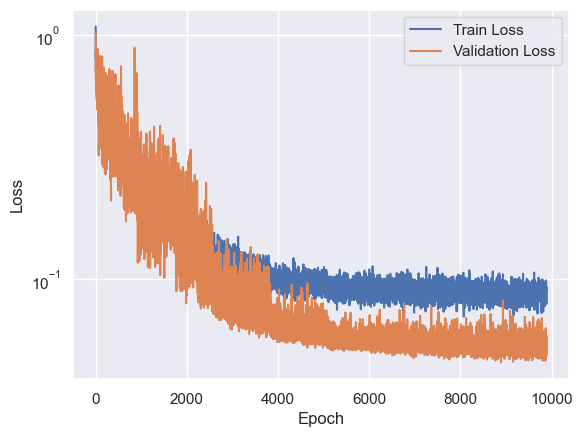

In [22]:
# Plot losses
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [46]:
# Test the model
test_loss = test(model, test_loader, loss_fn, device=device)
print("Test loss: ", test_loss)

Test loss:  0.05283636972308159


## Check the model

In [48]:
def predict_and_plot_ttf(model, test_TTF_data, test_Vs_data, freq_data, device, plot_true=True, idx=None, print_output=False):
    
    # Use the model to predict the TTF
    model.eval()

    # Ensure idx is within bounds
    if idx is None:
        idx = np.random.randint(0, len(test_TTF_data))
    else:
        assert 0 <= idx < len(test_TTF_data), "Index out of bounds"

    # Use test_TTF_data and test_Vs_data
    test_TTF_check = test_TTF_data[idx]
    test_Vs_check = test_Vs_data[idx] * np.ones_like(freq_data)

    # Normalize
    test_TTF_check = normalize_data(test_TTF_check, mean_TTF, std_TTF)
    test_Vs_check = normalize_data(test_Vs_check, mean_Vs, std_Vs)
    freq_data = normalize_data(freq_data, mean_freq, std_freq)
    
    # Create dataset
    test_check_dataset = TTFDataset(test_TTF_check, test_Vs_check, freq_data)

    # Create dataloader
    test_check_loader = DataLoader(test_check_dataset, batch_size=1, shuffle=False)

    # Predict
    predictions = []
    targets = []
    Vs_target = []
    freq_target = []
    with torch.no_grad():
        for X, y in test_check_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            predictions.append(y_pred.cpu().numpy())
            targets.append(y.cpu().numpy())
            Vs_target.append(X[:, 0].cpu().numpy())
            freq_target.append(X[:, -1].cpu().numpy())

    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    Vs_target = np.concatenate(Vs_target)
    freq_target = np.concatenate(freq_target)

    # Denormalize
    predictions = denormalize_data(predictions, mean_TTF, std_TTF)
    targets = denormalize_data(targets, mean_TTF, std_TTF)
    Vs_target = denormalize_data(Vs_target, mean_Vs, std_Vs)
    freq_target = denormalize_data(freq_target, mean_freq, std_freq)

    if print_output:
        print("Vs: ", Vs_target[0])
        #print("True TTF: ", targets)
        #print("Predicted TTF: ", predictions)

    # Plot
    if plot_true:
        plt.plot(freq_target, targets, label="True")
        plt.plot(freq_target, predictions, label="Predicted", linestyle="--")
        plt.legend()
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("TTF")
        plt.title(f"Vs: {Vs_target[0]}")
        plt.show()

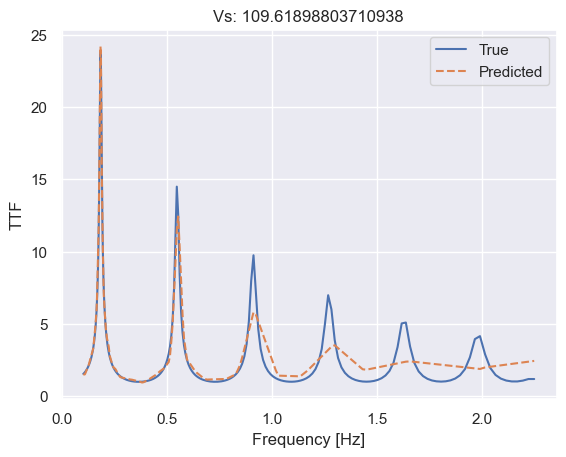

In [58]:
predict_and_plot_ttf(model, test_TTF_data, test_Vs_data, freq_data, device, plot_true=True, print_output=False)

In [26]:
# Predict and plot
model.eval()
predictions = []
target = []
Vs_target = []
freq_target = []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        predictions.append(y_pred.cpu().numpy())
        target.append(y.cpu().numpy()) 
        Vs_target.append(X[:, 0].cpu().numpy())
        freq_target.append(X[:, -1].cpu().numpy())


predictions = np.concatenate(predictions)
target = np.concatenate(target)
Vs_target = np.concatenate(Vs_target)
freq_target = np.concatenate(freq_target)

# Order frequency
order = np.argsort(freq_target)
freq_target = freq_target[order]
Vs_target = Vs_target[order]
predictions = predictions[order]
target = target[order]


# Denormalize
Vs_target = denormalize_data(Vs_target, mean_Vs, std_Vs)
predictions = denormalize_data(predictions, mean_TTF, std_TTF)
target = denormalize_data(target, mean_TTF, std_TTF)
freq_target = denormalize_data(freq_target, mean_freq, std_freq)

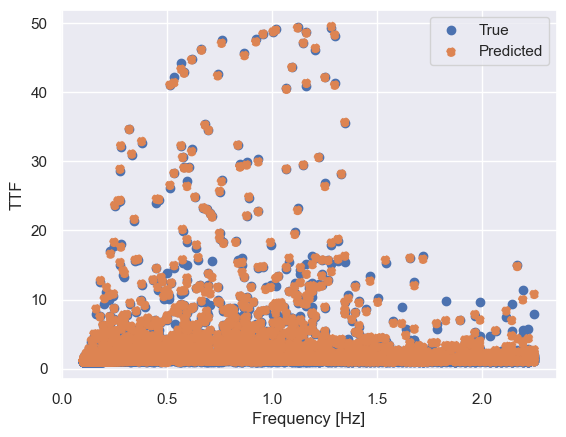

In [27]:
plt.scatter(freq_target, target, label="True")
plt.scatter(freq_target, predictions, label="Predicted", linestyle="--")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("TTF")
plt.show()


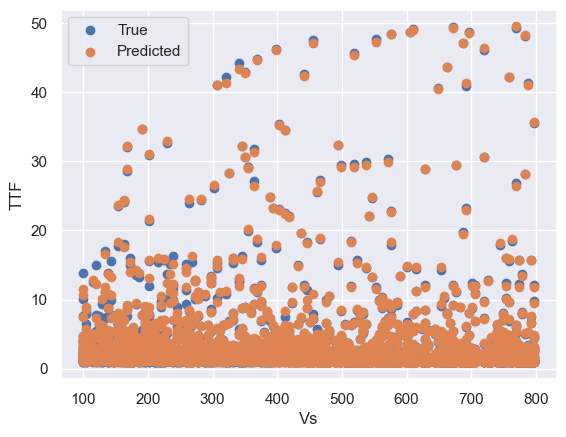

In [28]:
plt.scatter(Vs_target,target, label="True")
plt.scatter(Vs_target,predictions, label="Predicted")
plt.xlabel("Vs")
plt.ylabel("TTF")
plt.legend()
plt.show()


In [29]:
# Save the model
#torch.save(model.state_dict(), "MLP_TF_model.pt")

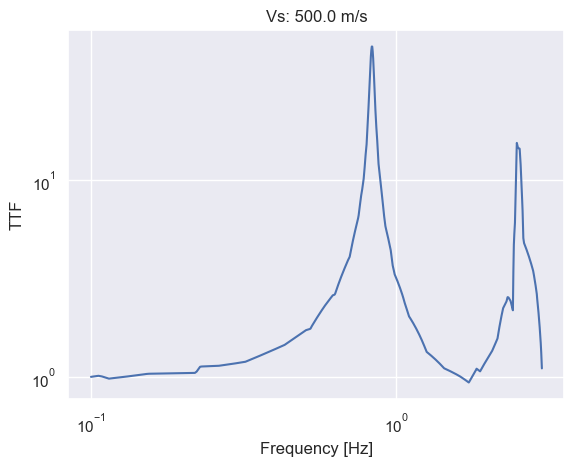

In [35]:
# Let's check with Vs = 1200 m/s

# Predict and plot
model.eval()
predictions = []

freq_2 = np.linspace(0.1, 3, 1000)
Vs_2 = 500 * np.ones_like(freq_2)

with torch.no_grad():
    for i in range(len(freq_2)):
        Vs = Vs_2[i] * np.ones(30)
        freq = freq_2[i] * np.ones(1)
        # Normalize
        Vs = normalize_data(Vs, mean_Vs, std_Vs)
        freq = normalize_data(freq, mean_freq, std_freq)

        # Create input data
        input_data = np.concatenate((Vs, freq))
        input_data = torch.tensor(input_data, dtype=torch.float32).to(device).unsqueeze(0)

        # Predict
        y_pred = model(input_data)
        predictions.append(y_pred.cpu().numpy())

predictions = np.concatenate(predictions)

# Denormalize
predictions = denormalize_data(predictions, mean_TTF, std_TTF)

plt.loglog(freq_2, predictions)
plt.xlabel("Frequency [Hz]")
plt.ylabel("TTF")
plt.title("Vs: {} m/s".format(Vs_2[0]))
plt.show()

